In [1]:
from collections import deque , namedtuple 
import gym
import tensorflow as tf 
import numpy as np 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense , Input 
from tensorflow.keras.losses import MSE 
from tensorflow.keras.optimizers import Adam 
import utils 
%load_ext autoreload 
%autoreload 2 

/home/moxitron/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [43]:
env = gym.make("LunarLander-v2")

In [3]:
state_size = env.observation_space.shape
num_actions = env.action_space.n 


Here is the psuedo code we'll be using to solve lunar lander. 
<br><br>
<figure>
  <img src = "assets/psuedo_code.png" width = 90% style = "border: thin silver solid; padding: 0px">
      <figcaption style = "text-align: center; font-style: italic">Fig 3. Deep Q-Learning with Experience Replay.</figcaption>
</figure>

Surely the most fundamental equations in reinforcement learning are Bellman Equations.
<br>
<br>

<center>           
$ \begin{equation} Q(s,a) = R(s) + \gamma \max_{a'} Q(s',a')\end{equation}$
</center>
<br>
Where $Q(s,a)$ is expected return when we are at state s and take action a, and $R(s)$ is reward when get when we are at state s.
There are $\sum_{s,a}$ variables and for each variable we have an equation. So one way to solve this is using system of linear equations.
<br>
In practice it's not the most efficient way. An alternative is to initialize $Q$ function randomely. It's most likely that left-hand side doesn't match and right-hand side in the Bellman equations. So we iterate over all state action pair and assign right-hand side to $Q(s,a)$. It can be proven that doing this over and over, the series of $Q$ functions converges and results in the optimal $Q$ funtion.
<br> 
There's an inconvenience to this. In Lunar Lander the space is infinite, hence it's practically impossible to go over all state-action pairs. Recall that neural networks can compute any function. One approach is to use NNs to estimate $Q^*$. And that's what we are gonna do.
<br>

###  Target Q network
We train NN to minimize error given below.          

$$ \begin{equation} \overbrace{\underbrace{R(s) + \gamma \max_{a'} Q(s',a' ; w)}_{y\,target} - Q(s,a ; w)}^{Error}\end{equation}$$

The value of $y target$ is changing, having a constantly changing target can lead to oscillations and instability. To resolve this issue we create another network, identical to $Q(s,a;w)$, $\hat{Q} (s,a ; w^- )$ and initialize its weights, $w^-$, to be same as $w$. We are only gonna update its weights every $C$ timesteps using **soft update** given by : 
 
$$ \begin{equation} w^- \leftarrow \tau w + (1 - \tau) w^- \end{equation} $$

where $\tau\ll1$. We'll get into what exprience replay means. For now let's implement $Q$ and $\hat{Q}$. 

In [4]:
######### CONSTANTS ###########
MEM_SIZE = 100_000         #size of the memory buffer
GAMMA = 0.995              #discount factor
ALPHA = 1e-3               #learning rate
NUM_STEPS_PER_UPDATE = 4 
NUM_EPISODES = 2_000 
MAX_NUM_TIMESTEPS = 1_000 
NUM_POINT_AVG = 100

In [41]:
q_network = Sequential([
    
    Input(state_size) , 
    Dense(64 , activation="relu") , 
    Dense(64 , activation="relu") , 
    Dense(num_actions  , activation="linear") , 
]) ; 
target_q_network = Sequential([
    
    Input(state_size) , 
    Dense(64 , activation="relu") , 
    Dense(64 , activation="relu") , 
    Dense(num_actions  , activation="linear") , 
    
]) ;
target_q_network.set_weights(q_network.get_weights()) ;
optimizer = Adam(learning_rate=ALPHA);

### Exprience replay 

When an agent interacts with the environment, the states, actions, and rewards the agent experiences are sequential by nature. If the agent tries to learn from these consecutive experiences it can run into problems due to the strong correlations between them. To avoid this, we employ a technique known as **Experience Replay** to generate uncorrelated experiences for training our agent. Experience replay consists of storing the agent's experiences (i.e the states, actions, and rewards the agent receives) in a memory buffer and then sampling a random mini-batch of experiences from the buffer to do the learning. The experience tuples $(S_t, A_t, R_t, S_{t+1})$ will be added to the memory buffer at each time step as the agent interacts with the environment.

For convenience, we will store the experiences as named tuples.

In [7]:
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

### Loss function 
To implement the loss function we need to shed some light on $y\,target$. The formula is given below and we will be using a mask to make it inline in the code. 
<br>
<br>
$$
\begin{equation} 
    y_j =  
    \begin{cases}
        R_j & \text {episode terminates at step } j + 1 \\
        R_j + \gamma \max_{a}\hat{Q}(s_j,a)
    \end{cases}
\end{equation}
$$
<br>

In [22]:
def compute_cost(expriences , gamma , q_network , target_q_network) :  
    """
    Returns cost using MSE function. 
    ------------------------------------
    Parameters : 
    
        expriences : list of namedtuples
            names are ["state", "action", "reward", "next_state", "done"]. 
        
        gamma : floating point 
            learning rate to use in Bellman Equations. 
        
        q_network : Keras Sequential model 
            network computing Q(s,a). 
        
        target_q_network : Keras Sequential model 
            network computing Q^(s,a). 
    """
    
    states , actions , rewards ,  next_states , done_vals = expriences
    max_qsa = tf.reduce_max(target_q_network(next_states) , axis=-1) 
    y_targets = rewards + gamma * ( 1 - done_vals ) * max_qsa 
    q_values = q_network(states) 
    q_values = tf.gather_nd(q_values , tf.stack([tf.range(q_values.shape[0]) , 
                                                tf.cast(actions , tf.int32)] , axis=1))
    loss = MSE(y_targets , q_values) 
    return loss

In [9]:
def update_networks(expriences , gamma) : 
    
    with tf.GradientTape() as tape :
        loss = compute_cost(expriences , gamma , q_network , target_q_network) 
        
    grads = tape.gradient(loss , q_network.trainable_variables) 
    optimizer.apply_gradients(zip(grads , q_network.trainable_variables)) 
    utils.update_target_network(q_network , target_q_network)

In [ ]:
epsilon = 1.0
total_points_history = [] 
memory_buffer = deque(maxlen=MEM_SIZE) 

for i in range(NUM_EPISODES) :
    
    state = env.reset() 
    points = 0 
    for t in range(MAX_NUM_TIMESTEPS) : 
        
        q_vals = q_network(state.reshape(1 , -1)) 
        action = utils.get_action(q_vals, epsilon)
        next_state , reward , done , _ = env.step(action)
        
        memory_buffer.append(experience(state , action , reward , next_state , done)) 
        
        if utils.check_update_conditions(t,NUM_STEPS_PER_UPDATE,
                                         len(memory_buffer)) :
            
            experiences = utils.get_experiences(memory_buffer) 
            update_networks(experiences , GAMMA) 
        
        state = next_state.copy()
        points += reward 
        if done : 
            break 
    
    total_points_history.append(points) 
    avg_latest_points = np.mean(total_points_history[-NUM_POINT_AVG:])
    epsilon = utils.get_new_epsilon(epsilon) 
    utils.print_episode_info(i , NUM_POINT_AVG , avg_latest_points) 
    
    if avg_latest_points >= 200.0 : 
        print(f"Environment solved in {i + 1} episodes")
        q_network.save("NN.h5")
        break 
            

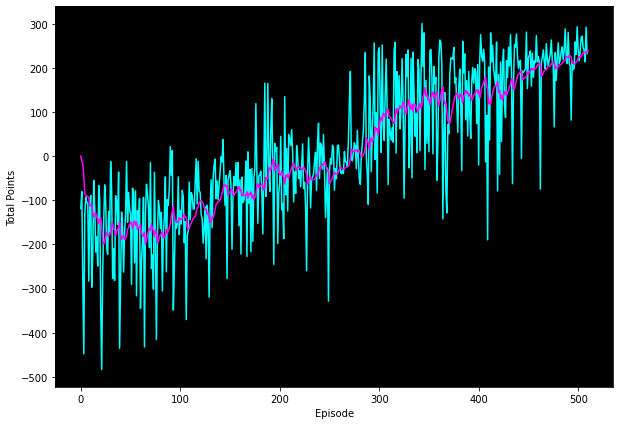

In [54]:
utils.plot_history(total_points_history)

In [ ]:
utils.make_video("landing.mp4" , env , q_network) 